In [66]:
#this is to auto-reload modules (like utils.py)
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
from IPython.display import clear_output

import os
import sys
import time
import gc
import json
import glob
import ast

import shutil
import joblib
import itertools

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)


#needed to import utils.py
sys.path.append('../') 

import utils
import utils_exec_models
import utils_exec_models_new

import numpy as np
import pandas as pd
# config to not reduce column width
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)


import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap

import seaborn as sns
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('seaborn-whitegrid')

    
import plotly as ply
import plotly.express as px

from itertools import permutations, combinations

from tabulate import tabulate

import pickle
from joblib import dump, load


import sklearn
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier


# from xgboost import XGBClassifier
# from catboost import CatBoostClassifier


import imblearn.under_sampling as resus
import imblearn.ensemble as resemb
import imblearn.combine as reshyb
from imblearn.over_sampling  import SMOTE


import shap
shap.initjs()

# import interpret

from collections import Counter


# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.filterwarnings('always')

# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn




SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%matplotlib inline  



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display


### Get Training, Validation, Balanced sets 

##### NOTE: the "training_sets" contains the sets of training and validation to help the models execution, with the following information:
 - `Dataset Info `  ["Training", "Training Balanced"]
 - `Features Info`  ["All Features", "Feature Selection"]
 - `"X" to train`   
 - `"y" to train` 
 - `"X" to validation`


In [67]:
# get train and tezt sets INCLUDING the Diagnosis_Delay feature
X_train, y_train, X_valid, y_valid = utils.get_train_and_validation_data(
    scaled=True,
    use_diagnosis_delay=True
)

X_all = pd.concat([X_train, X_valid])
y_all = np.concatenate((y_train, y_valid))


display(X_all)

,Sex_Male,Site_Onset,Diagnosis_Delay,Age_at_Onset,Riluzole,FVC_at_Diagnosis,BMI_at_Diagnosis,Q1_Speech_slope_at_Diagnosis,Q2_Salivation_slope_at_Diagnosis,Q3_Swallowing_slope_at_Diagnosis,Q4_Handwriting_slope_at_Diagnosis,Q5_Cutting_slope_at_Diagnosis,Q6_Dressing_and_Hygiene_slope_at_Diagnosis,Q7_Turning_in_Bed_slope_at_Diagnosis,Q8_Walking_slope_at_Diagnosis,Q9_Climbing_Stairs_slope_at_Diagnosis,Q10_Respiratory_slope_at_Diagnosis,Qty_Regions_Involved_at_Diagnosis,Region_Involved_Bulbar_at_Diagnosis,Region_Involved_Upper_Limb_at_Diagnosis,Region_Involved_Lower_Limb_at_Diagnosis,Region_Involved_Respiratory_at_Diagnosis,Patient_with_Gastrostomy_at_Diagnosis
0,1.0,1.0,0.0,0.50,0.0,1.0,0.67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.67,1.0,1.0,1.0,0.0,0.0
1,1.0,1.0,0.5,0.75,0.0,0.0,0.67,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.5,0.0,0.67,1.0,1.0,1.0,0.0,0.0
2,1.0,1.0,0.0,0.25,0.0,1.0,0.33,0.5,0.0,0.0,0.5,0.5,0.5,0.0,0.0,0.5,0.0,0.67,1.0,1.0,1.0,0.0,0.0
3,0.0,0.0,0.5,0.50,0.0,1.0,1.00,0.5,0.5,0.5,0.0,0.0,0.5,0.5,0.5,0.5,0.5,0.67,1.0,0.0,1.0,1.0,0.0
4,1.0,0.0,1.0,0.75,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,1.00,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,0.0,1.0,0.0,0.25,0.0,1.0,0.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.67,0.0,1.0,1.0,1.0,0.0
390,0.0,1.0,1.0,0.75,0.0,1.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.00,0.0,0.0,1.0,0.0,0.0
391,0.0,1.0,0.0,0.75,0.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.00,0.0,0.0,1.0,0.0,0.0
392,0.0,1.0,0.0,0.75,0.0,1.0,0.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.67,0.0,1.0,1.0,1.0,0.0


In [2]:
# X_train, X_train_fs, y_train, \
# X_train_balanced, X_train_fs_balanced, y_train_balanced,\
# X_valid, X_valid_fs, y_valid, training_sets = utils.get_train_and_validation_data(
#     return_training_sets=True
# )


# X_all = pd.concat([X_train, X_valid])
# X_all_fs = pd.concat([X_train_fs, X_valid_fs])
# y_all = np.concatenate((y_train, y_valid))


# display(X_train)


,Diagnosis_Delay,Age_Range_at_Onset,Riluzole,Sex_Male,Site_Onset,FVC,BMI,Q1_Speech_slope,Q2_Salivation_slope,Q3_Swallowing_slope,Q4_Handwriting_slope,Q5_Cutting_slope,Q6_Dressing_and_Hygiene_slope,Q7_Turning_in_Bed_slope,Q8_Walking_slope,Q9_Climbing_Stairs_slope,Q10_Respiratory_slope,Qty_Regions_Involved,Region_Involved_Bulbar,Region_Involved_Upper_Limb,Region_Involved_Lower_Limb,Region_Involved_Respiratory,Patient_with_Gastrostomy
0,1.0,0.50,0.0,1.0,1.0,0.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.75,1.0,1.0,1.0,0.0,0.0
1,0.5,0.75,0.0,1.0,1.0,0.0,0.75,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.5,0.0,0.75,1.0,1.0,1.0,0.0,0.0
2,1.0,0.25,0.0,1.0,1.0,0.0,0.50,0.5,0.0,0.0,0.5,0.5,0.5,0.0,0.0,0.5,0.0,0.75,1.0,1.0,1.0,0.0,0.0
3,0.5,0.50,0.0,0.0,0.0,1.0,1.00,0.5,0.5,0.5,0.0,0.0,0.5,0.5,0.5,0.5,0.5,0.75,1.0,0.0,1.0,1.0,0.0
4,0.0,0.75,0.0,1.0,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,1.00,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1568,0.5,0.50,0.0,0.0,0.0,1.0,0.50,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.0,1.00,1.0,1.0,1.0,1.0,1.0
1569,0.5,0.50,0.0,1.0,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,1.0,1.0,1.0,1.0,0.0
1570,1.0,0.50,0.0,1.0,1.0,0.0,1.00,0.5,0.0,0.0,0.0,1.0,1.0,0.5,0.0,0.0,1.0,0.75,1.0,1.0,0.0,1.0,0.0
1571,1.0,0.75,1.0,1.0,1.0,1.0,0.50,0.0,0.0,0.5,0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.00,1.0,1.0,1.0,1.0,0.0


---
# Create the best model selected between the bests

In [68]:
# BalancedBaggingClassifier

estimator = DecisionTreeClassifier(class_weight='balanced',max_depth=4,random_state=42)

params = {'n_estimators':7,'random_state':42,'replacement':True,'sampling_strategy':'all','warm_start':True}

clf = resemb.BalancedBaggingClassifier(estimator=estimator, **params)

clf

BalancedBaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                           max_depth=4,
                                                           random_state=42),
                          n_estimators=7, random_state=42, replacement=True,
                          sampling_strategy='all', warm_start=True)

---
# Train the best model using the $Training$ set 

In [69]:
clf.fit(X=X_train, y=y_train)

BalancedBaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                           max_depth=4,
                                                           random_state=42),
                          n_estimators=7, random_state=42, replacement=True,
                          sampling_strategy='all', warm_start=True)

---
# Make predictions using the Validation set

In [70]:
y_pred = clf.predict(X=X_valid)
y_pred_proba = clf.predict_proba(X=X_valid)[:,1]

#get performance
bal_acc, sens, spec, auc, acc, prec, f1 = utils_exec_models_new.get_performances_from_predictions(
    y_validation=y_valid, 
    y_pred=y_pred,
    y_pred_proba=y_pred_proba,
)

performance = {
    'bacc': bal_acc,
    'sens': sens,
    'spec': spec,
    'auc': auc,
}

print(performance)



{'bacc': 0.88, 'sens': 0.96, 'spec': 0.81, 'auc': 0.94}


---
---
# Perform SHAP to analyze the feature importances

In [ ]:
#Get shap values
# explainer = shap.TreeExplainer(clf)
# shap_values = explainer.shap_values(X_valid)

# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X)

explainer = shap.KernelExplainer(clf.predict, X_all)
shap_values = explainer(X_all)

Using 1967 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
 32%|███████████▌                        | 634/1967 [2:15:18<4:44:50, 12.82s/it]

In [50]:
file_explainer = 'saved_shap_explainer/SHAP_Explainer_BalBag_DT.model'
with open(file_explainer, 'wb') as file:
    pickle.dump(explainer, file)

# to_serialize = open(file, 'wb') 
# pickle.dump(explainer, to_serialize)

#save SHAP Values object
file_explainer_values = 'saved_shap_explainer/SHAP_Explainer_values_BalBag_DT.model'
with open(file_explainer_values, 'wb') as file:
    pickle.dump(shap_values, file)

# to_serialize = open(file, 'wb') 
# pickle.dump(shap_values, to_serialize)


-------------
Beeswarm plot
-------------


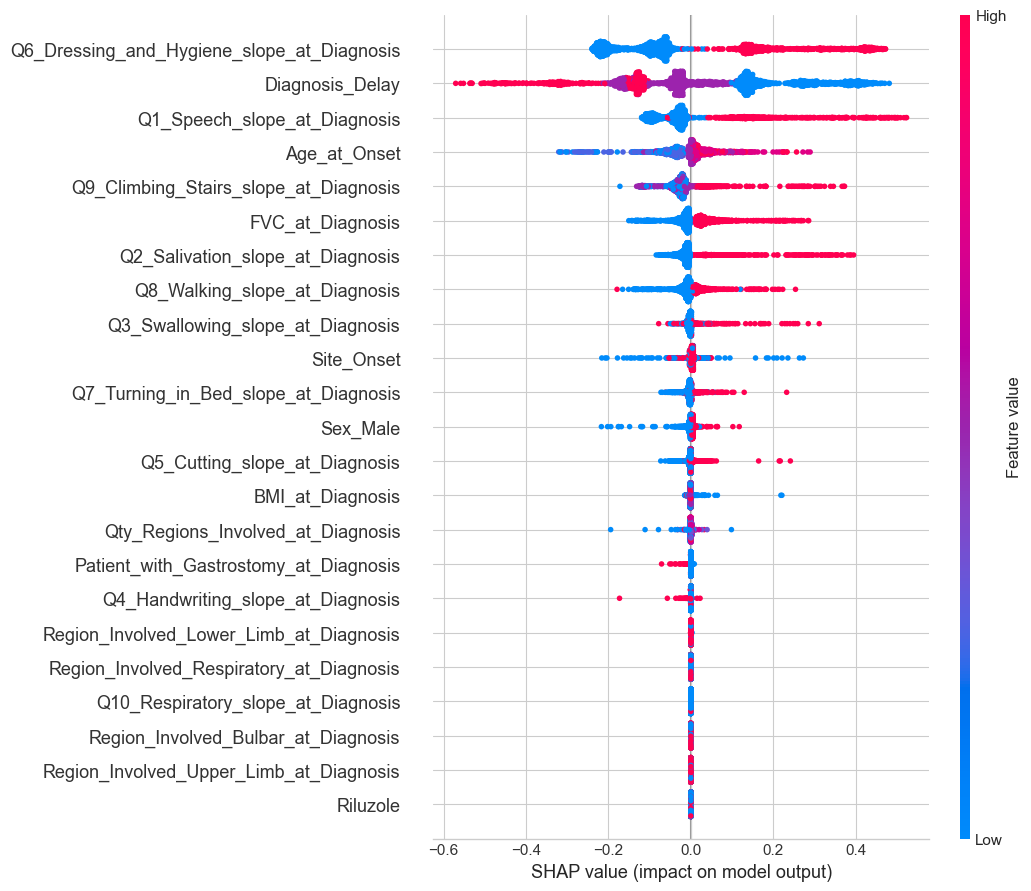

In [51]:
utils.print_string_with_separators('Beeswarm plot')
shap.plots.beeswarm(shap_values, max_display=25)

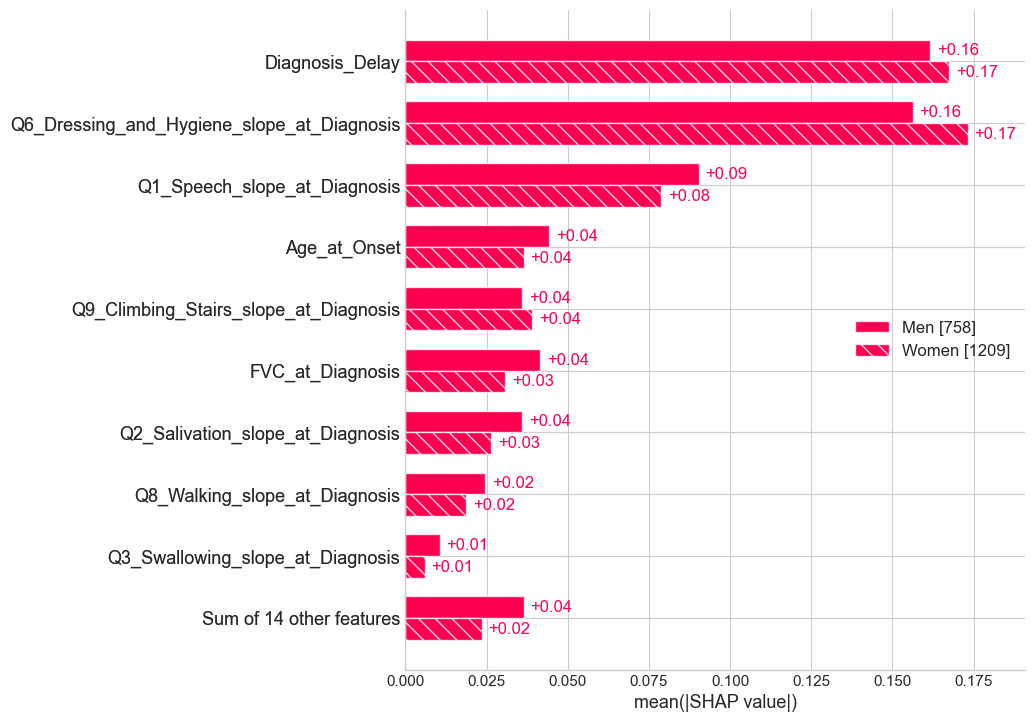

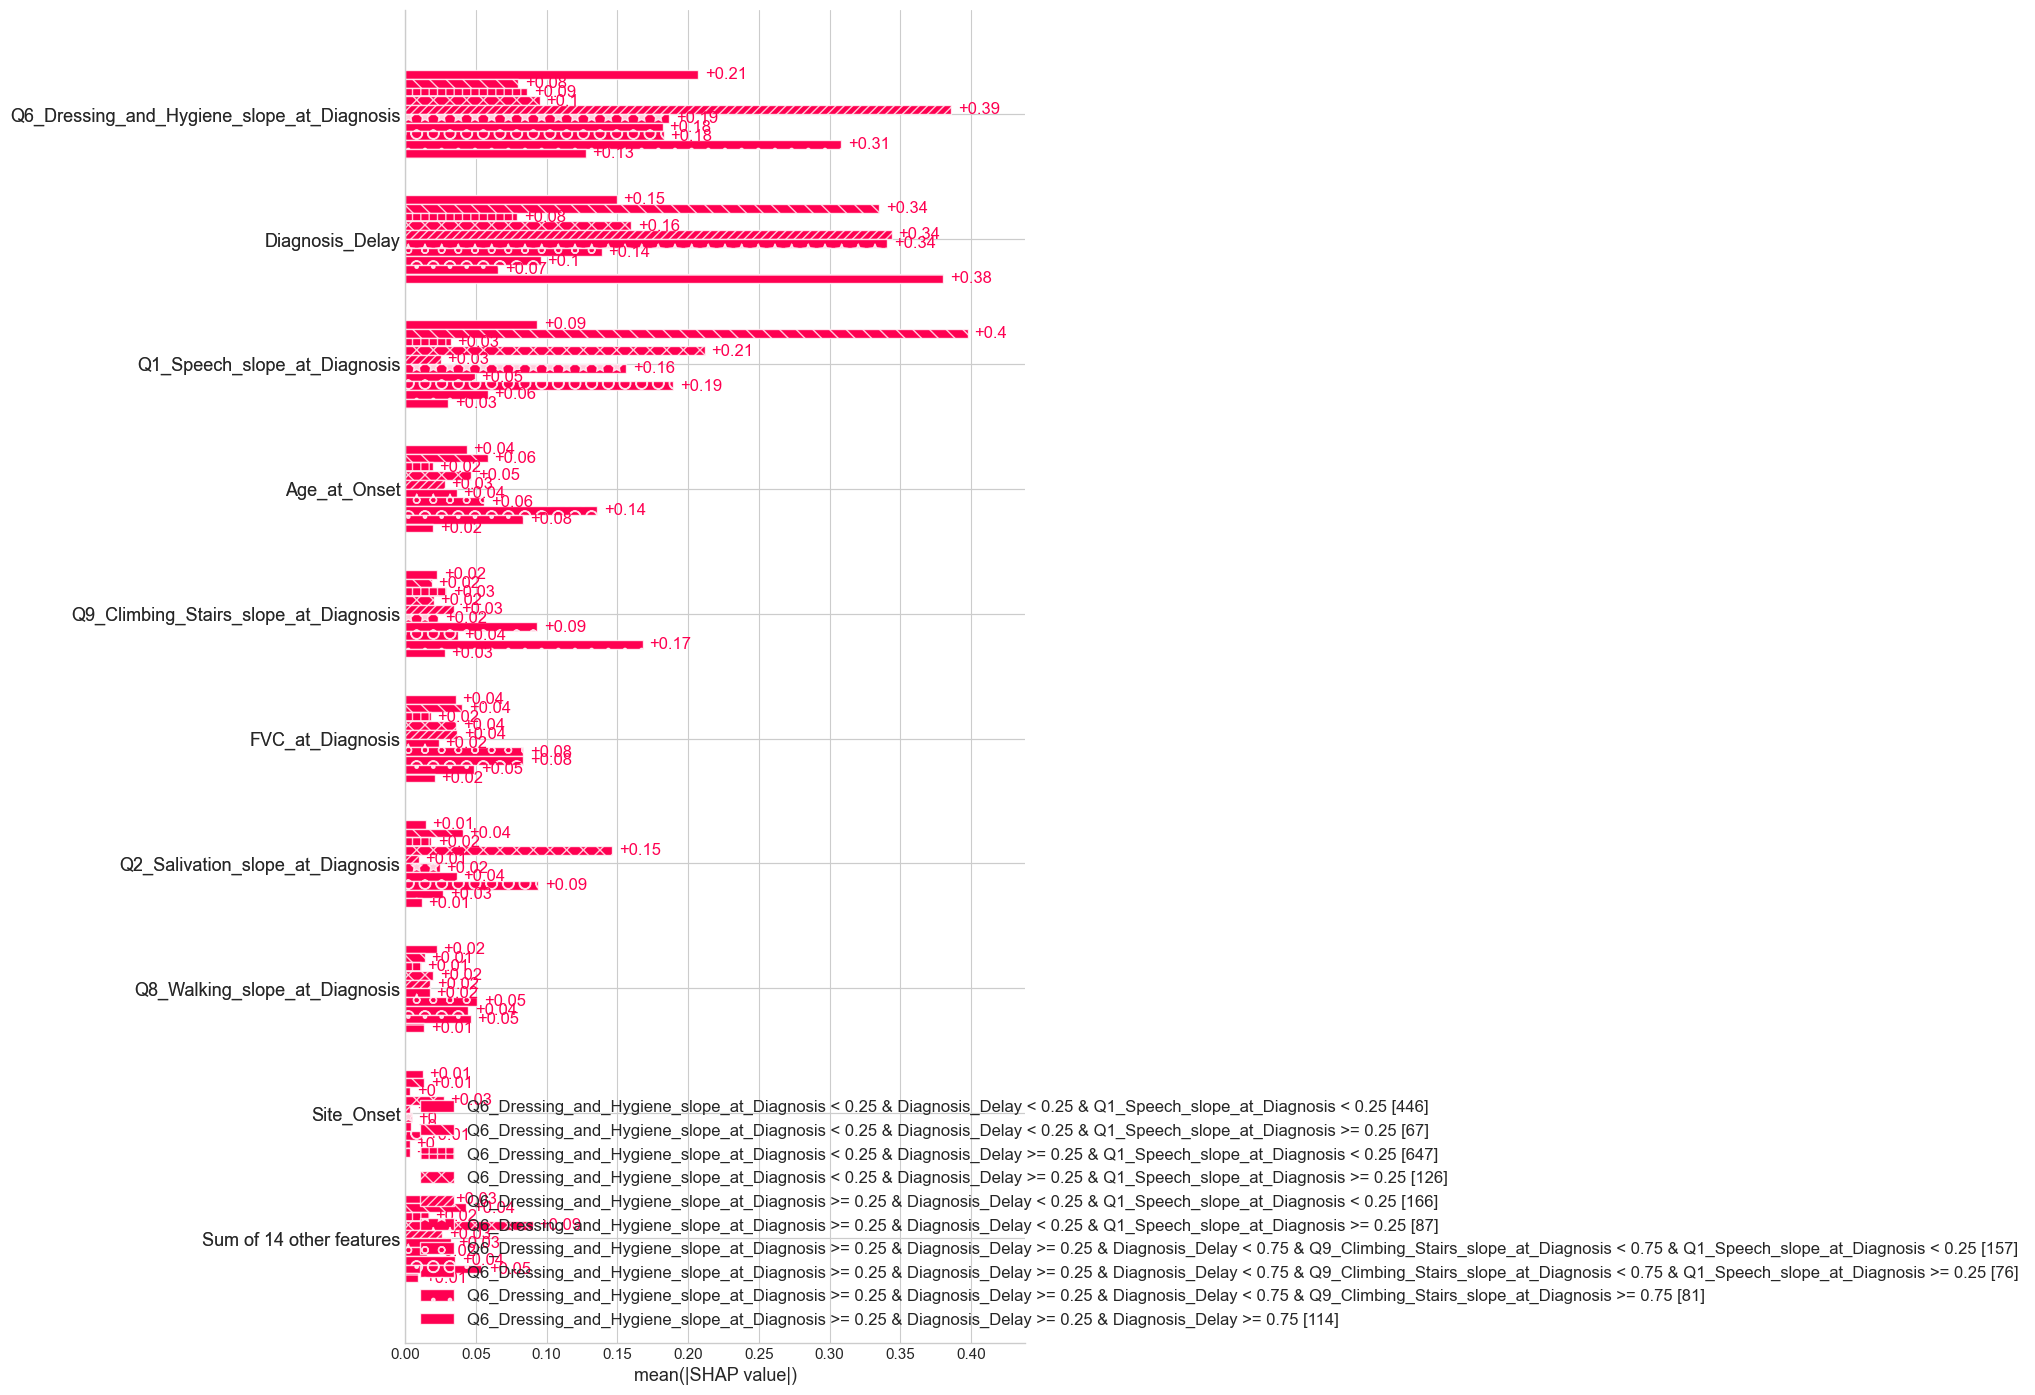

-------------
Beeswarm plot
-------------


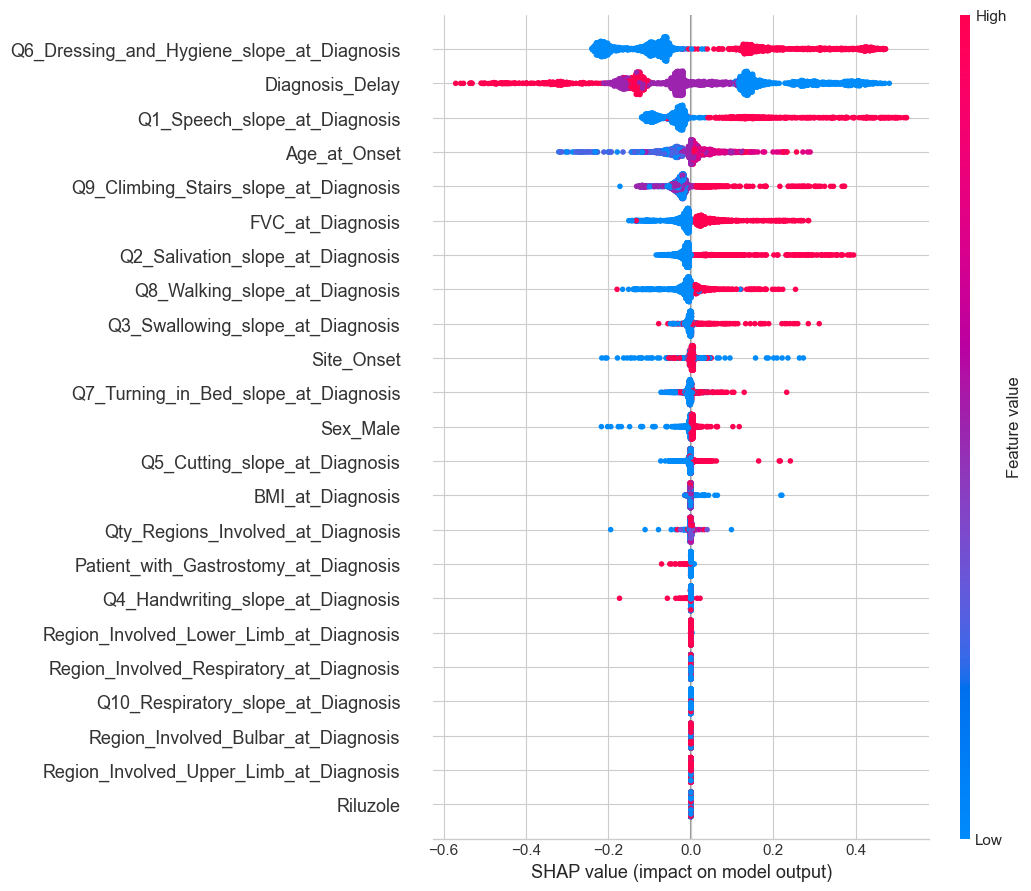

---------
Mean SHAP
---------


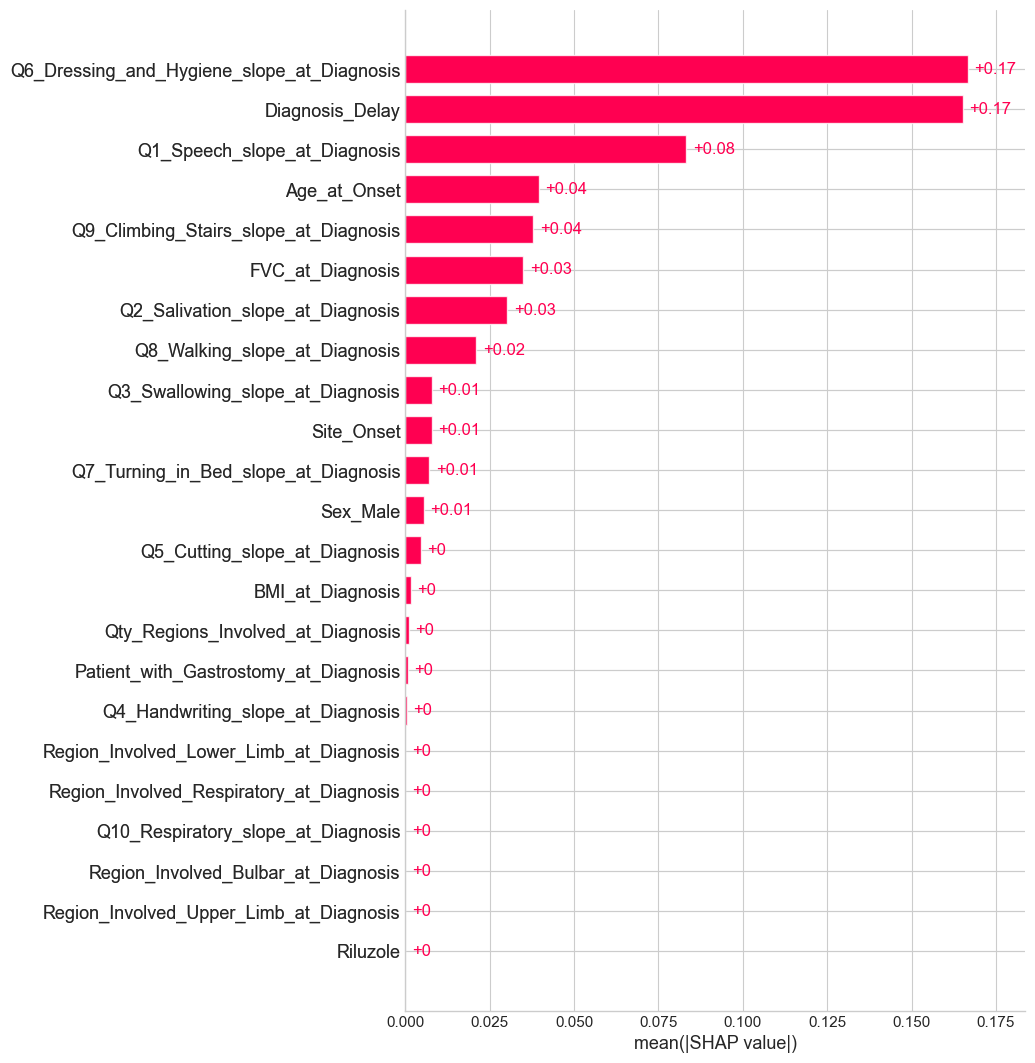

---------
Waterfall
---------


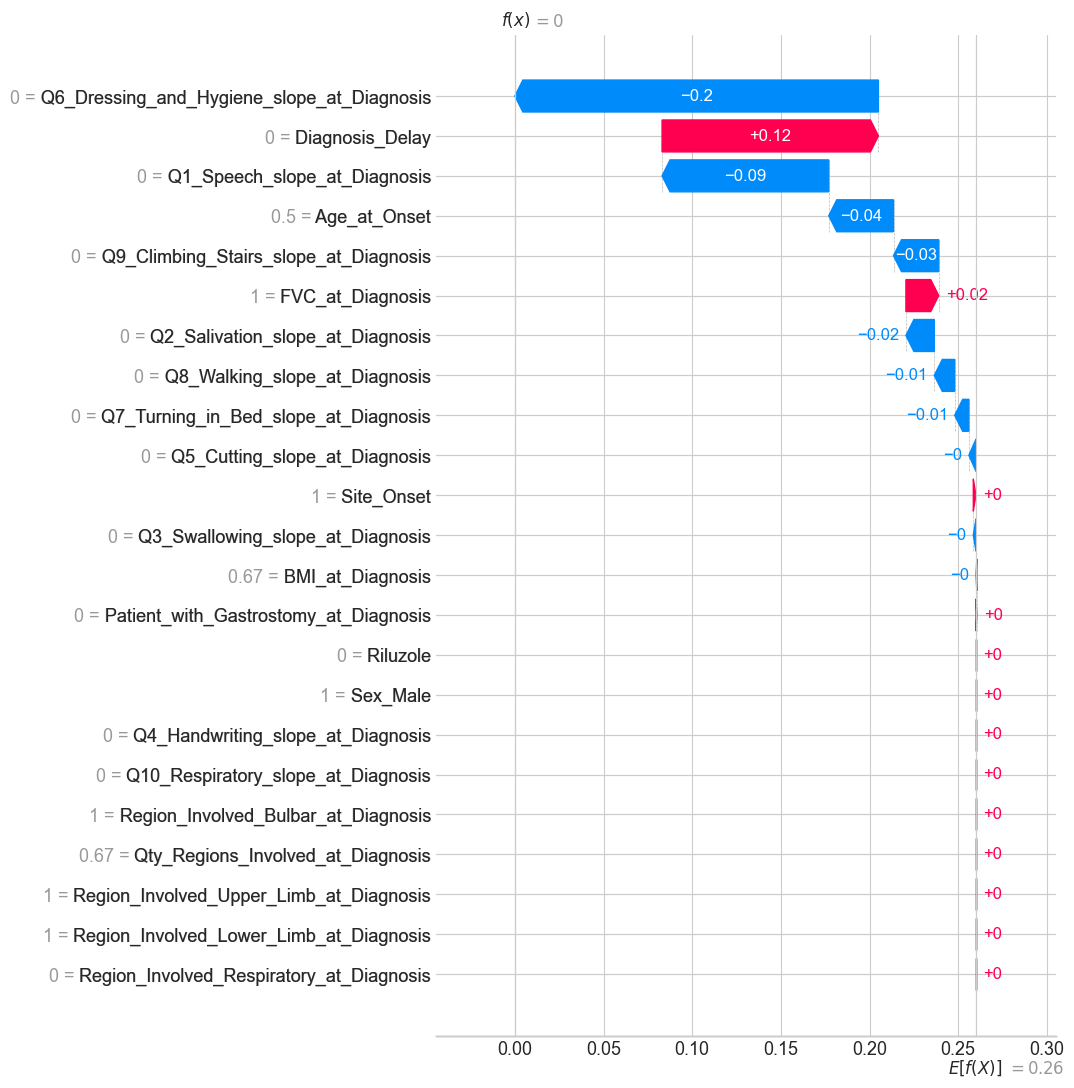

---------
Forceplot
---------
------------------
Stacked force plot
------------------


In [52]:
sex = ["Women" if shap_values[i,"Sex_Male"].data == 1 else "Men" for i in range(shap_values.shape[0])]
shap.plots.bar(shap_values.cohorts(sex).abs.mean(0))

shap.plots.bar(shap_values.cohorts(10).abs.mean(0))

utils.print_string_with_separators('Beeswarm plot')
shap.plots.beeswarm(shap_values, max_display=25)

utils.print_string_with_separators('Mean SHAP')
shap.plots.bar(shap_values, max_display=25)

utils.print_string_with_separators('Waterfall')
shap.plots.waterfall(shap_values[0], max_display=25)

utils.print_string_with_separators('Forceplot')
shap.plots.force(shap_values[0])

utils.print_string_with_separators('Stacked force plot')
shap.plots.force(shap_values[0:500])

# shap.plots.waterfall(shap_values[500])
# shap.plots.waterfall(shap_values[1499])

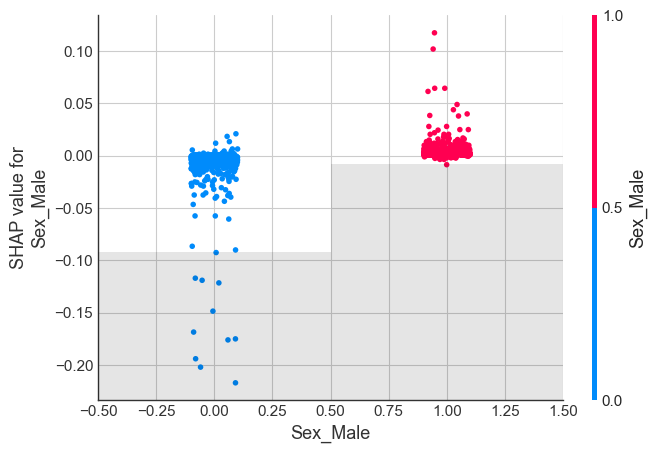

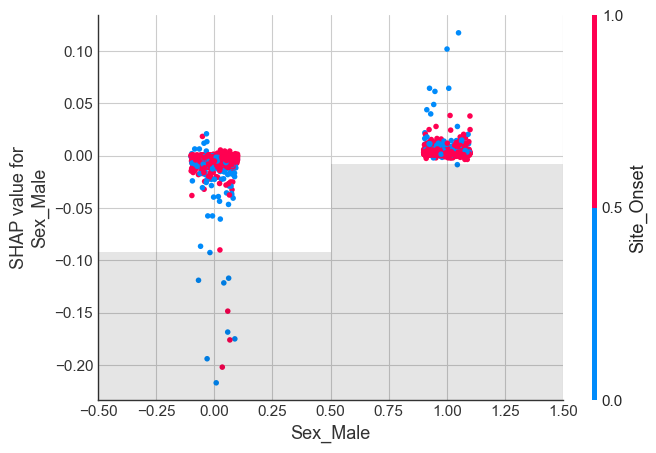

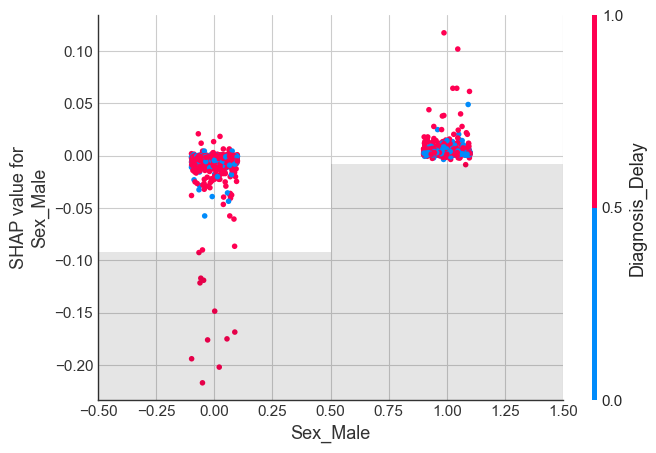

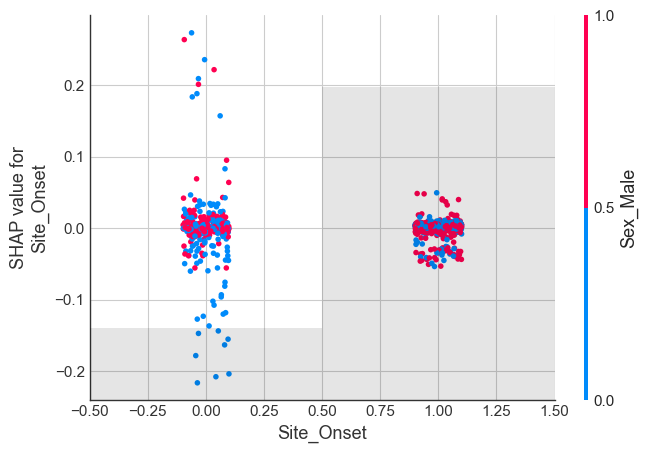

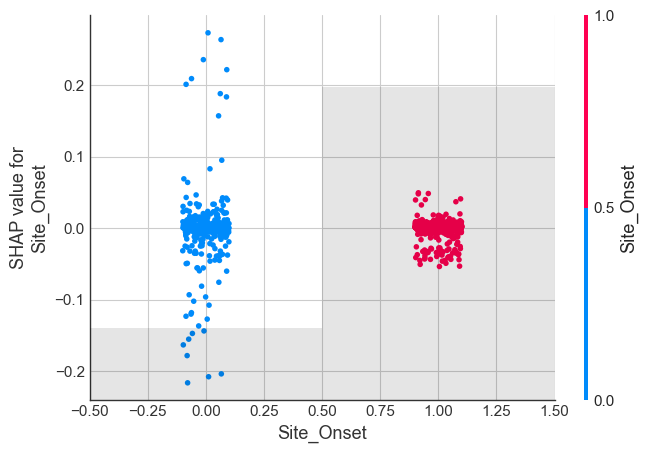

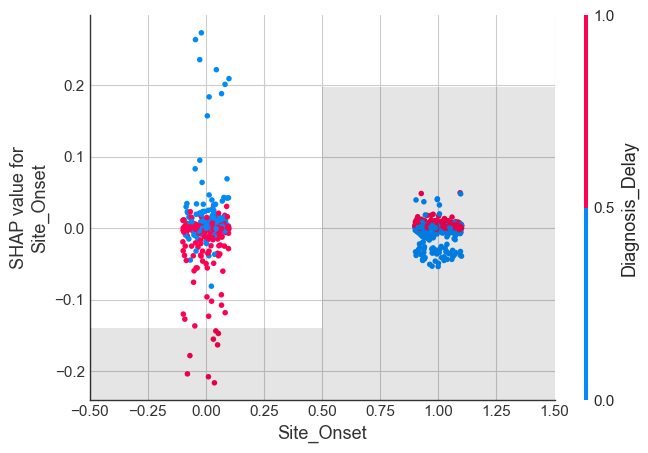

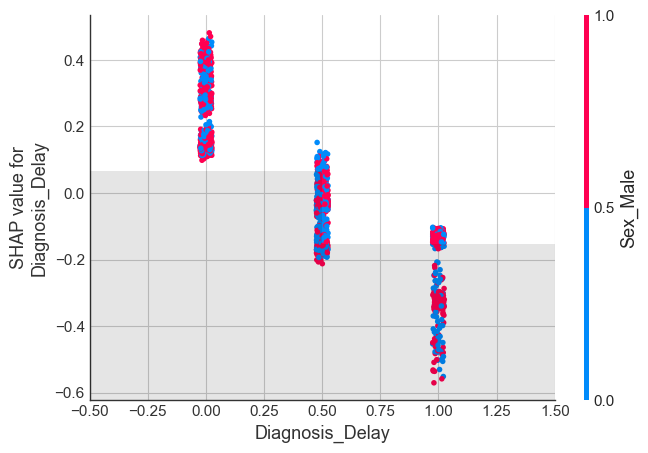

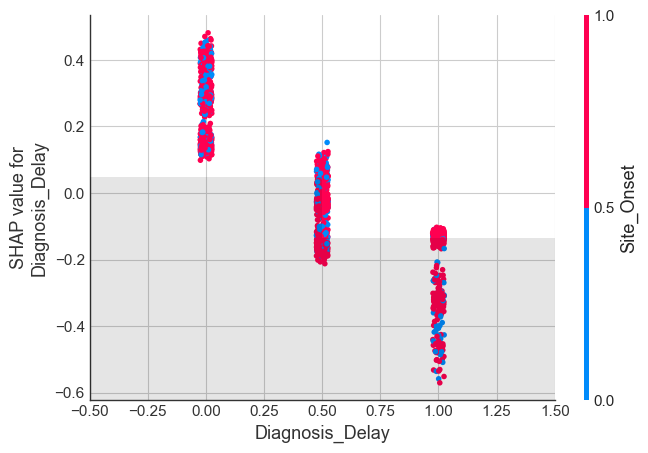

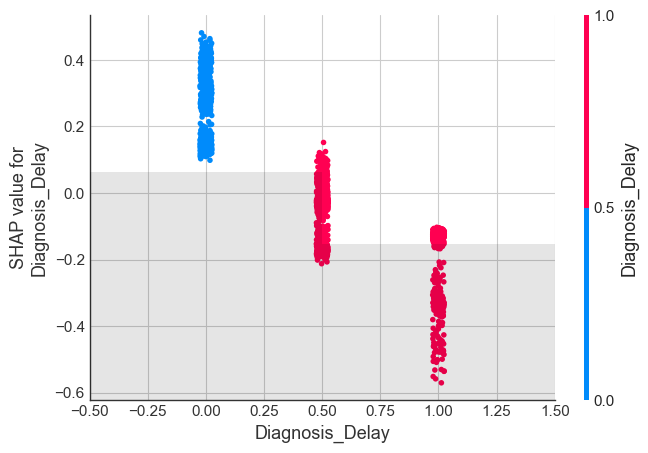

In [55]:
for feat1 in shap_values.feature_names[0:3]:
    for feat2 in shap_values.feature_names[0:3]:
        shap.plots.scatter(
            shap_values[:,feat1],
            color=shap_values[:,feat2]
        )


In [56]:
display(shap_values.feature_names)

['Sex_Male',
 'Site_Onset',
 'Diagnosis_Delay',
 'Age_at_Onset',
 'Riluzole',
 'FVC_at_Diagnosis',
 'BMI_at_Diagnosis',
 'Q1_Speech_slope_at_Diagnosis',
 'Q2_Salivation_slope_at_Diagnosis',
 'Q3_Swallowing_slope_at_Diagnosis',
 'Q4_Handwriting_slope_at_Diagnosis',
 'Q5_Cutting_slope_at_Diagnosis',
 'Q6_Dressing_and_Hygiene_slope_at_Diagnosis',
 'Q7_Turning_in_Bed_slope_at_Diagnosis',
 'Q8_Walking_slope_at_Diagnosis',
 'Q9_Climbing_Stairs_slope_at_Diagnosis',
 'Q10_Respiratory_slope_at_Diagnosis',
 'Qty_Regions_Involved_at_Diagnosis',
 'Region_Involved_Bulbar_at_Diagnosis',
 'Region_Involved_Upper_Limb_at_Diagnosis',
 'Region_Involved_Lower_Limb_at_Diagnosis',
 'Region_Involved_Respiratory_at_Diagnosis',
 'Patient_with_Gastrostomy_at_Diagnosis']

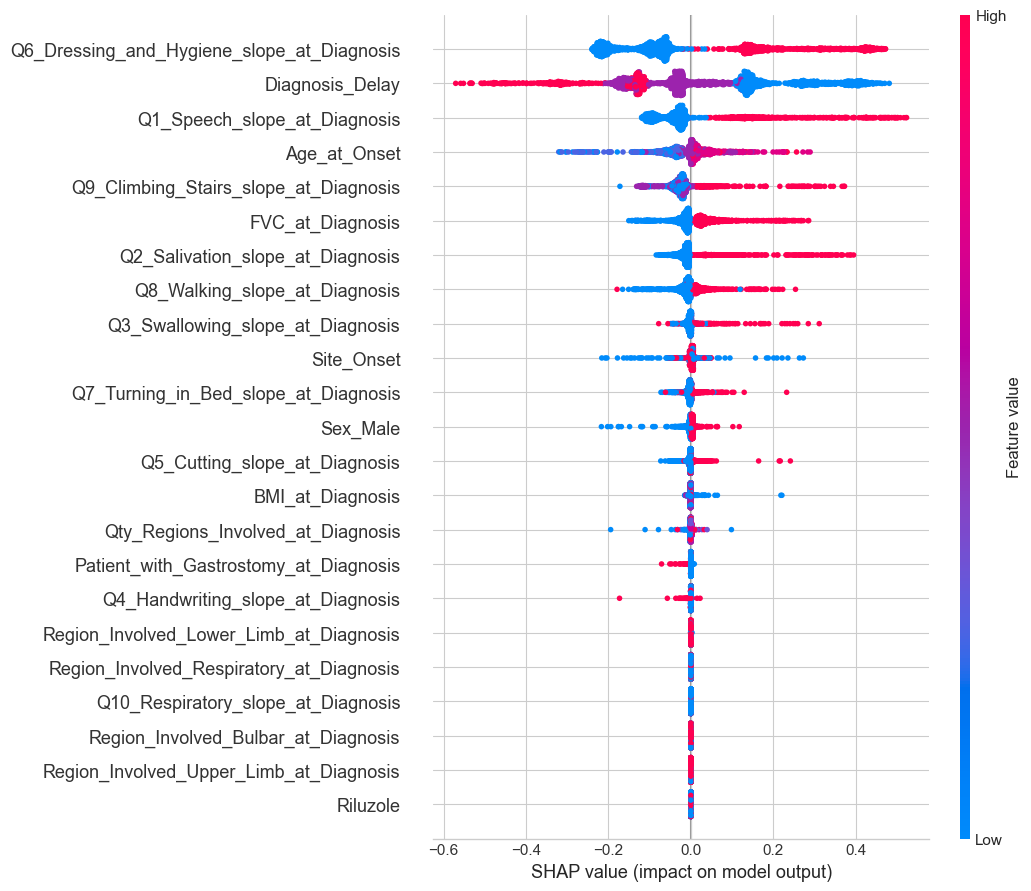

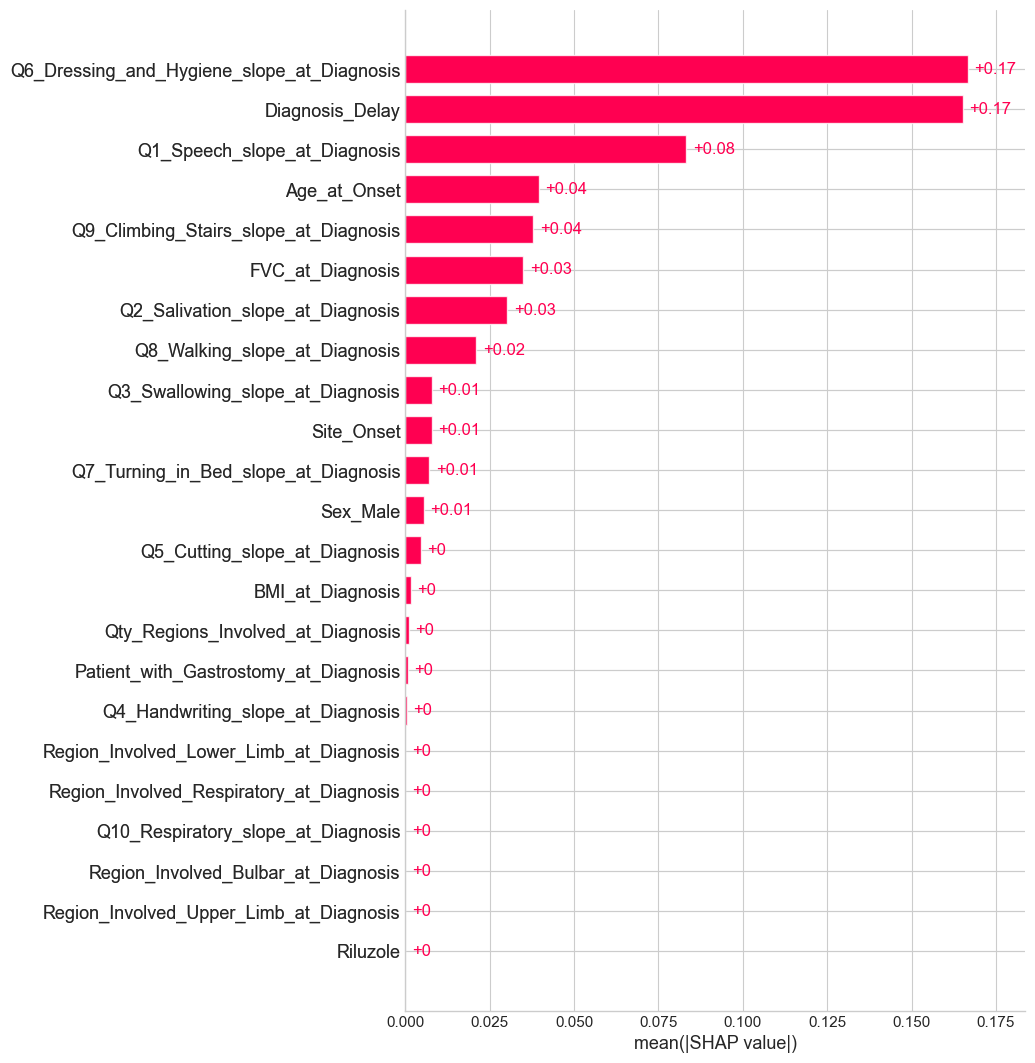

In [57]:

# Load all from disk to keep the example short.
with open(file_explainer_values, 'rb') as fl:
    shap_values_loaded = pickle.load(fl)

# display(shap_values_loaded)

# class_count = len(shap_values_loaded.base_values)
# display(class_count)


shap.plots.beeswarm(
    shap_values_loaded, 
    max_display=25
)

shap.plots.bar(
    shap_values_loaded, 
    max_display=25,
)


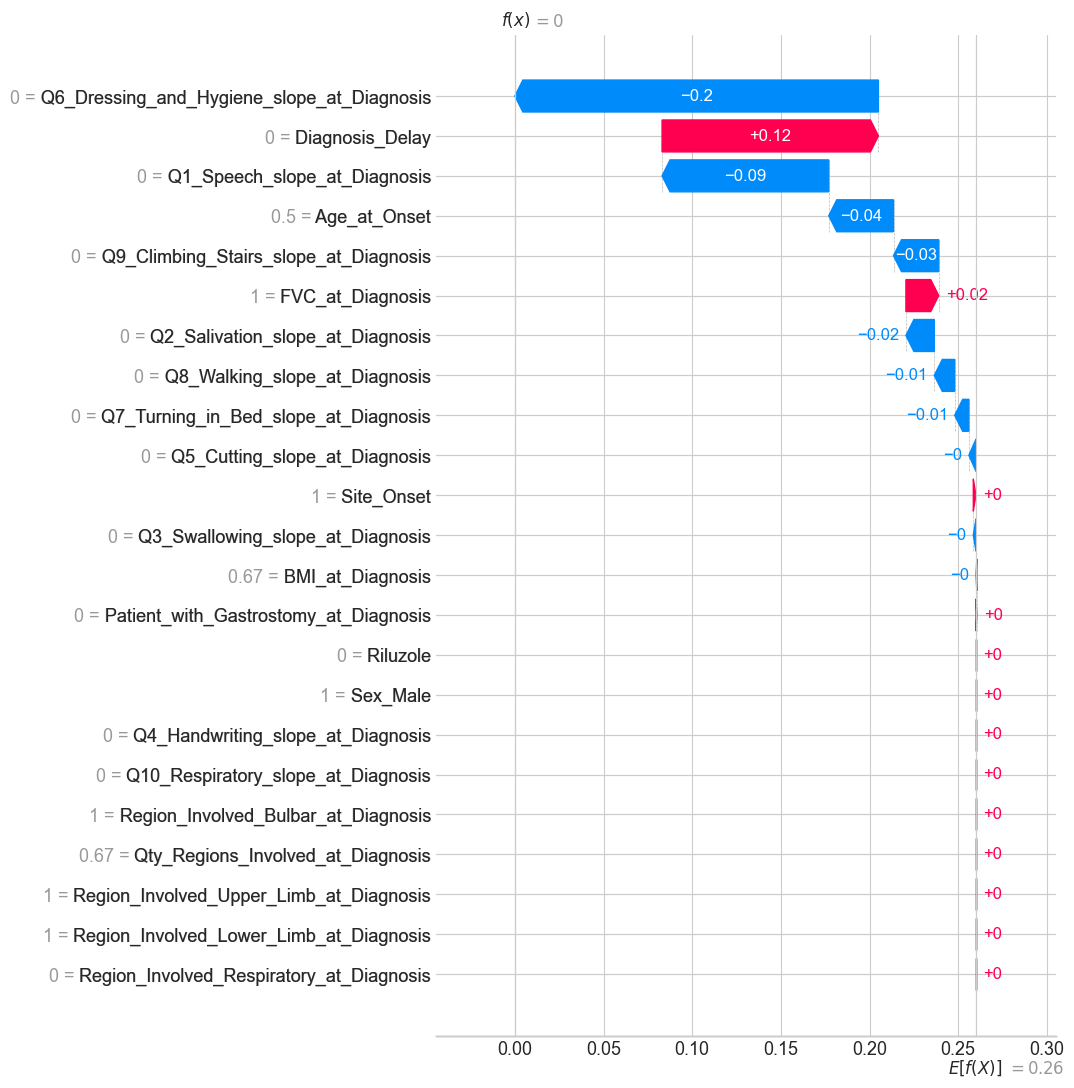

In [64]:
shap.plots.waterfall(shap_values[0], max_display=25)